# Tutorial: using DeepInterpolation with SpikeInterface

## Background

* A neural network based denoiser for neural data from Jerome Lecoq at AIBS
  * https://www.nature.com/articles/s41592-021-01285-2
  * demonstration on ophys, fMRI, ephys etc   
* Normally, supervised learning requires (data, label)
* E.g. for denoising images, data would be image corrupted with noise and label would be image without noise
* But obtaining noise-free data is almost impossible, unless one can sample many times and average over them
* How to denoise with a single sample?
* Key idea: nearby pixels/samples tend to be similar
  * predict the value of a target pixel with the surround pixels
  * Assumptions: data = signal + noise; signal and noise are statistically independent
  * the model tries to predict the target pixel value; but can only predict signal 
* Application to ephys:
![fig](./fig.png)


## DeepInterpolation in SpikeInterface
* There is now a `DeepInterpolatedRecording` that takes any SI recording object as input
* Inference is applied lazily; i.e. when `get_traces` is called.


Get sample data (1-min Neuropixels 1.0 recording from Josh) via `kachery cloud`.

In [1]:
import kachery_cloud as kcl
import spikeinterface.full as si
import probeinterface as pi

# Load recording
uri = 'ipfs://bafybeihqetpnwdiiujilgr4psqhjbriitaf2gk4ili3fjioonhfquj23ce?label=continuous_1min.dat?label=hackathon_example_data_allen/Neuropix-PXI-100_ProbeA-AP/continuous_1min.dat'
fname = kcl.load_file(uri)

rec = si.BinaryRecordingExtractor(fname, sampling_frequency=30000, num_chan=384, dtype='int16')
probe_group = pi.read_probeinterface("/home/kyu/repos/spike-sorting-hackathon/datasets/examples/NP1_standard_config.json")
rec = rec.set_probegroup(probe_group)
print(rec)

# Print recording information
print('')
print(f'Sampling frequency (Hz): {rec.get_sampling_frequency()}')
print(f'Duration (minutes): {rec.get_total_duration() / 60}')
print(f'Num. channels: {rec.get_num_channels()}')

BinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 60.000s
  file_paths: ['/home/kyu/.kachery-cloud/ipfs/uj/23/ce/bafybeihqetpnwdiiujilgr4psqhjbriitaf2gk4ili3fjioonhfquj23ce']

Sampling frequency (Hz): 30000
Duration (minutes): 1.0
Num. channels: 384


Apply band-pass filter.

In [2]:
# Filter
filt_rec = si.bandpass_filter(rec, freq_min=300, freq_max=5000)

Apply DI. This loads the pre-trained model. Note that the user must specify the parameters of the model (e.g. pre and post frames).

In [3]:
from spikeinterface.preprocessing.deepinterpolation import deepinterpolate
di_rec = deepinterpolate(filt_rec, model_path='2020_02_29_15_28_unet_single_ephys_1024_mean_squared_error-1050.h5',
                         pre_frames=30, post_frames=30, pre_post_omission=1, use_gpu=True)

2022-07-03 22:44:10.616761: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


DI is applied when `get_traces` is called.

In [4]:
import time

start_frame = 0
end_frame = 30000

filt_traces = filt_rec.get_traces(start_frame=start_frame, end_frame=end_frame)

t1 = time.time()
di_traces = di_rec.get_traces(start_frame=start_frame,end_frame=end_frame)
t2 = time.time()
print(f'Elapsed:{t2-t1} s')

2022-07-03 22:44:14.200483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-03 22:44:14.537782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7656 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-07-03 22:44:14.546063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
/home/kyu/miniconda3/envs/spikeinterface/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are

Elapsed:11.688899993896484 s


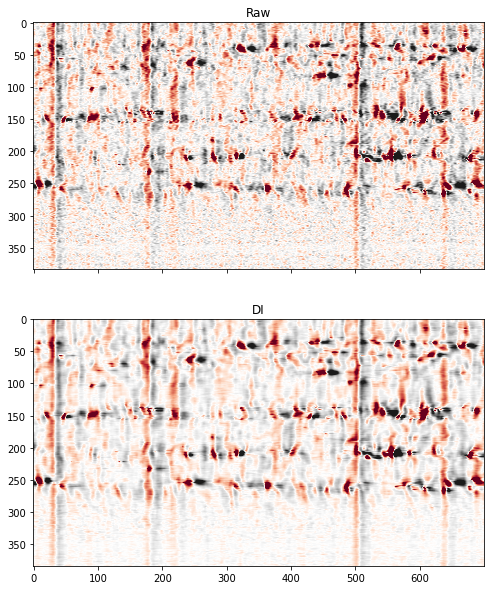

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(10,10),sharex=True, sharey=True)

ax[0].imshow(filt_traces[1100:1800,:].T, cmap='RdGy', vmin=-250, vmax=250)
ax[0].title.set_text('Raw')

ax[1].imshow(di_traces[1100:1800,:].T, cmap='RdGy', vmin=-250, vmax=250)
ax[1].title.set_text('DI')


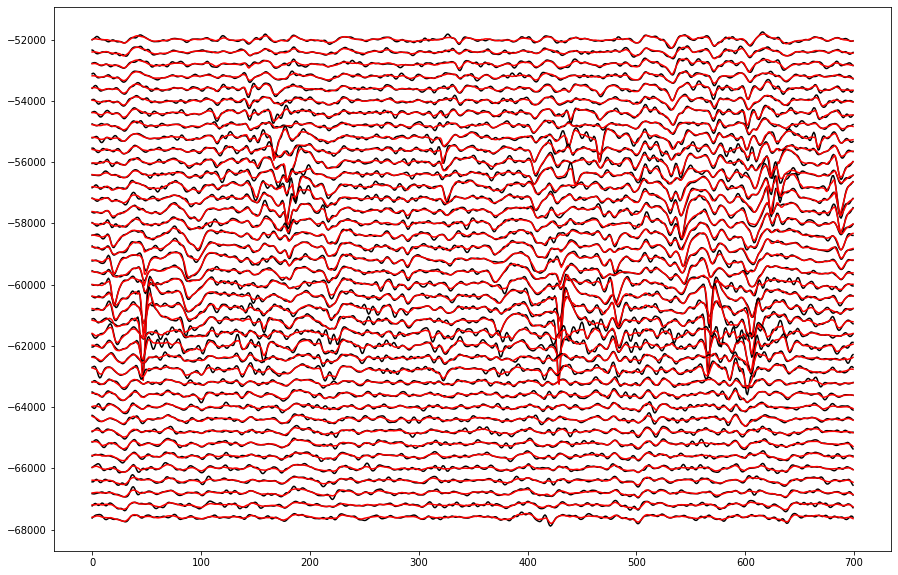

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
for i in range(130,170):
    ax.plot(filt_traces[1100:1800,i]-i*400, 'k', label='Raw')
    ax.plot(di_traces[1100:1800,i]-i*400, 'r', label='DI')

## How to extend DI to arbitrary probe geometry?

The original model in Lecoq 2021 is trained on the Neuropixels 1.0 data. This probe has a specific number of channels (384) and geometry (two columns, rows zigzag). 

The recording is reshaped and converted to a series of (384, 2) images (every other element is zero). 

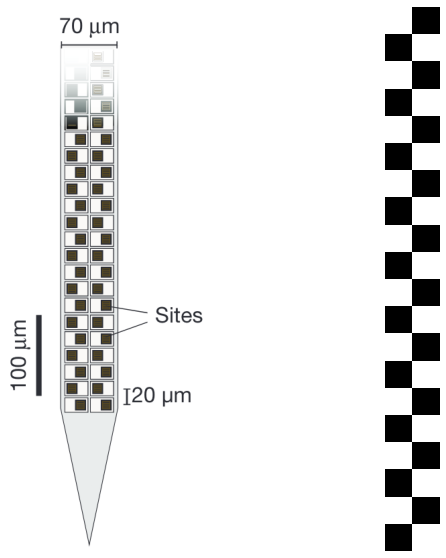

In [7]:
import matplotlib.image as mpimg
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(10,10))
reshaped_npx = np.zeros((20,2))
reshaped_npx[1::2,0] = 1
reshaped_npx[0::2,1] = 1
img = mpimg.imread('npx.png')
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(reshaped_npx, cmap='Greys')
ax[1].axis('off');

How can we apply it to data obtained with probes with different channel count and geometry?

1. Retrain the network so that it can take input with different size
    * WIP
2. Create a 'dummy' Neuropixels 1.0 recording
    * e.g. for a tetrode data (4 channels), just append 380 channels to it that contain only zero
    * this eliminates spatial information, which may be important. But wouldn't hurt to try?

Slice a part of the example data to get a fake tetrode. Then create a fake Neuropixels 1.0 recording by appending the `ZeroRecording`.

In [8]:
tet_rec = filt_rec.channel_slice(channel_ids=filt_rec.channel_ids[150:154])
zero_rec = si.zero_channelpad(tet_rec, num_chans=384)
di_zero_rec = deepinterpolate(zero_rec, model_path='2020_02_29_15_28_unet_single_ephys_1024_mean_squared_error-1050.h5',
                              pre_frames=30, post_frames=30, pre_post_omission=1, use_gpu=True)

Apply DI

In [11]:
import time

start_frame = 0
end_frame = 2500

tet_traces = tet_rec.get_traces(start_frame=start_frame, end_frame=end_frame)

t1 = time.time()
di_zero_traces = di_zero_rec.get_traces(start_frame=start_frame,end_frame=end_frame)
t2 = time.time()

print(f'Elapsed:{t2-t1} s')

2022-07-03 22:44:44.103087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7656 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:17:00.0, compute capability: 8.6
/home/kyu/miniconda3/envs/spikeinterface/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Elapsed:1.358313798904419 s


Plot result

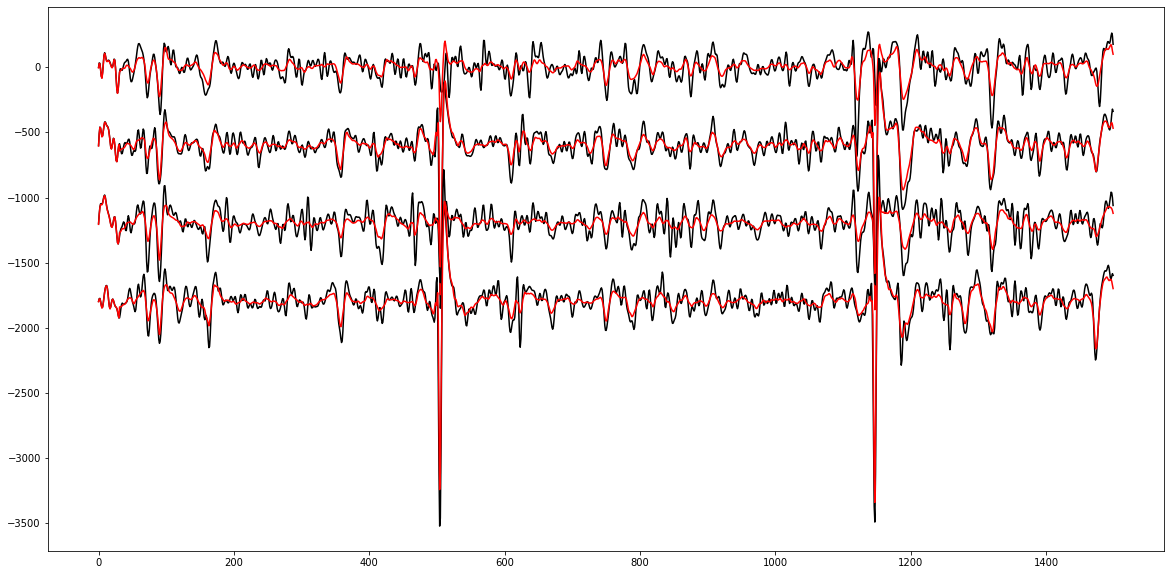

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
for i in range(4):
    ax.plot(tet_traces[:1500,i]-i*600, 'k')
    ax.plot(di_zero_traces[:1500,i]-i*600, 'r')